In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [3]:
noise_model = get_noise(0.01)

In [4]:
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
          execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

00 becomes {'01': 103, '00': 9808, '10': 85, '11': 4}
01 becomes {'01': 9795, '00': 116, '10': 1, '11': 88}
10 becomes {'01': 1, '00': 99, '10': 9801, '11': 99}
11 becomes {'01': 99, '00': 2, '10': 110, '11': 9789}


In [5]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'01': 104, '00': 4888, '10': 93, '11': 4915}


In [10]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [11]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [12]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
       ░ ┌─┐   
q1_0: ─░─┤M├───
       ░ └╥┘┌─┐
q1_1: ─░──╫─┤M├
       ░  ║ └╥┘
c1_0: ════╩══╬═
             ║ 
c1_1: ═══════╩═
               

Circuit mcalcal_01
      ┌───┐ ░ ┌─┐   
q1_0: ┤ X ├─░─┤M├───
      └───┘ ░ └╥┘┌─┐
q1_1: ──────░──╫─┤M├
            ░  ║ └╥┘
c1_0: ═════════╩══╬═
                  ║ 
c1_1: ════════════╩═
                    

Circuit mcalcal_10
            ░ ┌─┐   
q1_0: ──────░─┤M├───
      ┌───┐ ░ └╥┘┌─┐
q1_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c1_0: ═════════╩══╬═
                  ║ 
c1_1: ════════════╩═
                    

Circuit mcalcal_11
      ┌───┐ ░ ┌─┐   
q1_0: ┤ X ├─░─┤M├───
      ├───┤ ░ └╥┘┌─┐
q1_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c1_0: ═════════╩══╬═
                  ║ 
c1_1: ════════════╩═
                    



In [13]:
# Execute the calibration circuits without noise
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [14]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [15]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 113, '00': 4856, '10': 111, '11': 4920}


In [16]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

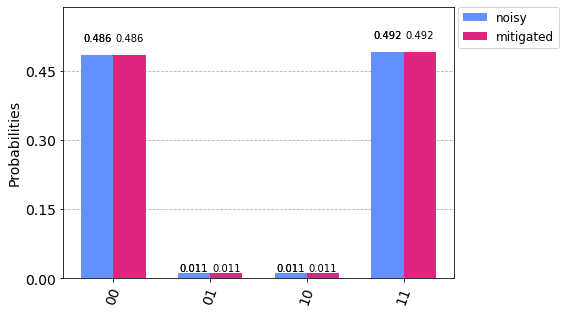

In [17]:
from qiskit.visualization import plot_histogram 
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])